<img style="float: left;;" src='Figures/iteso.jpg' width="100" height="200"/></a>

# <center> <font color= #000047>Aplicando Python para análisis de precios: simulación de escenarios futuros de precios</font> </center>




<img style="float: right; margin: 0px 0px 15px 15px;" src="https://upload.wikimedia.org/wikipedia/commons/d/d7/Philippine-stock-market-board.jpg" width="400px" height="125px" />

> En la clase anterior vimos como importar datos de activos de la base de datos de Yahoo Finance usando el paquete pandas-datareader. En esta clase, veremos como pronosticar escenarios de evolución de precios, suponiendo que los rendimientos diarios se distribuyen normalmente. Como esta evolución de precios es aleatoria, utilizaremos la simulación montecarlo (hacer muchas simulaciones de escenarios de evolución de precios) para obtener probabilidades de que los precios de cierre estén encima de un valor umbral y tomar decisiones con base en estas probabilidades.

**Referencias:**
- http://pandas.pydata.org/
- http://www.learndatasci.com/python-finance-part-yahoo-finance-api-pandas-matplotlib/

## 1. Recordemos como descargar datos...

Antes que nada, para poder hacer simular escenarios de predicción de precios, vamos a recordar lo que hicimos en la clase pasada de descargar los datos de Yahoo Finance, utilizando el paquete `data` de la librería `pandas_datareader`.

Esta vez, utilizaremos los datos de precios de cierre ajustados de activos de la compañía Apple en el año 2016 para nuestra aplicación.

In [1]:
# Importamos librerías
from pandas_datareader import data as web
import pandas as pd
import numpy as np
import yfinance


In [2]:
yfinance.pdr_override()

In [3]:
# Función para descargar precios de cierre ajustados de varios activos a la vez:
def get_closes(tickers, start_date=None, end_date=None):
    closes = web.get_data_yahoo(tickers, start=start_date, end = end_date, interval ='1d')['Adj Close']
    closes = closes.sort_index()
    return closes

In [4]:
# Descargamos datos...
# Instrumento: Apple
name = ['AAPL', 'WMT']
start = '2016-01-01'
end = '2023-01-01'
# Función para descargar los datos
closes = get_closes(tickers=name, start_date=start, end_date=end)

[*********************100%***********************]  2 of 2 completed


In [5]:
closes.head()

,AAPL,WMT
Date,,
2016-01-04,23.977478,52.529293
2016-01-05,23.376619,53.777126
2016-01-06,22.919142,54.315594
2016-01-07,21.951847,55.580528
2016-01-08,22.067926,54.307041


<AxesSubplot:xlabel='Date'>

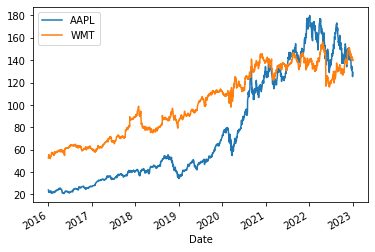

In [6]:
closes.plot()

## 2. Simulación de rendimientos diarios

Recordemos que los precios diarios de cierre ajustados no son un proceso estocástico estacionario, pero los rendimientos diarios si lo son. Por tanto calculamos los rendimientos a partir de los precios de cierre, obtenemos sus propiedades estadísticas muestrales y proyectamos los rendimientos. Luego, obtenemos la proyección de los precios.

Para una sucesión de precios $\{S_t\}_{t=0}^{n}$, el rendimiento simple $R_t$ se define como el el cambio porcentual

$$
R_t=\frac{S_t-S_{t-1}}{S_{t-1}}\approx \ln\left(\frac{S_t}{S_{t-1}}\right)=r_t.
$$
para $t=1,\ldots,n$.

Para el ejemplo en curso, ¿cómo calcular esto?

Además, supusimos que los rendimientos diarios eran una variable aleatoria con distribución normal (que se caracteriza con su media y varianza). Por tanto obtenemos la media y desviación estandar muestrales. Hagamos una función que retorne lo anterior.

In [10]:
ret = closes.pct_change().dropna()
ret.head()

,AAPL,WMT
Date,,
2016-01-05,-0.025059,0.023755
2016-01-06,-0.019570,0.010013
2016-01-07,-0.042205,0.023289
2016-01-08,0.005288,-0.022912
2016-01-11,0.016192,0.010702


<AxesSubplot:xlabel='Date'>

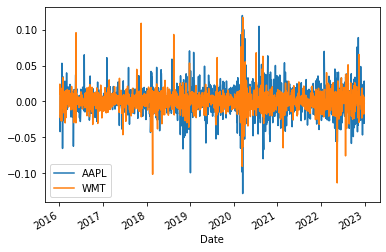

In [11]:
ret.plot()

Entonces, suponemos que la diferencia logaritmica de los precios (rendimientos diarios) tiene una distribución normal.

¿Cómo se caracteriza una [distribución normal](https://es.wikipedia.org/wiki/Distribuci%C3%B3n_normal)?

In [13]:
mu_AAPL = np.mean(ret['AAPL'].values)
std_AAPL = np.std(ret['AAPL'].values)
mu_AAPL, std_AAPL

(0.0011400722354179963, 0.01913392268100495)

In [14]:
# Calculamos media y desviación estándar
mu = ret.mean()
std = ret.std()

In [15]:
mu

AAPL    0.001140
WMT     0.000655
dtype: float64

In [16]:
std

AAPL    0.019139
WMT     0.014019
dtype: float64

In [17]:
from matplotlib import pyplot as plt

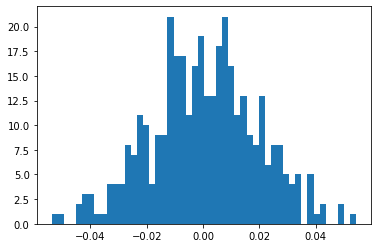

In [19]:
simu = np.random.normal(mu_AAPL, std_AAPL, size=365)
plt.figure(figsize=(6,4))
H_AAPL = plt.hist(simu, bins=50)
plt.show()

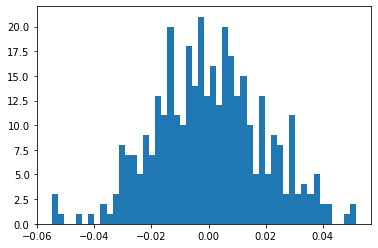

In [26]:
#La distgribución normal para AAPL
simu = np.random.normal(mu_AAPL, std_AAPL, size=365)
plt.figure(figsize=(6,4))
H_AAPL = plt.hist(simu, bins=50)
plt.show()

In [27]:
type(mu)

pandas.core.series.Series

In [28]:
mu['WMT'], std['WMT']

(0.0006554760250920748, 0.014019262025010526)

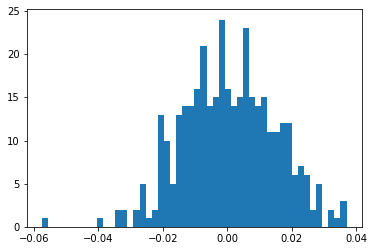

In [29]:
#La distgribución normal para WMT
simu = np.random.normal(mu['WMT'], std['WMT']
                        , size=365)
plt.figure(figsize=(6,4))
H_WMT = plt.hist(simu, bins=50)
plt.show()

Habiendo caracterizado los rendimientos diarios como una variable aleatoria normal con la media y la varianza muestral obtenida de los datos del 2016 - 2023, podemos generar números aleatorios con estas características para simular el comportamiento de los precios de cierre de las acciones en el >2023-01 (hay un supuesto de que las cosas no cambiarán fundamentalmente).

Sin embargo, cada simulación que hagamos nos conducirá a distintos resultados (los precios siguen evolucionando aleatoriamente). Entonces, lo que haremos es simular varios escenarios para así ver alguna tendencia y tomar decisiones.

Hagamos una una función que simule varios escenarios de rendimientos diarios rendimientos diarios y que devuelva un dataframe con esta simulación.

In [31]:
ret.tail()

,AAPL,WMT
Date,,
2022-12-23,-0.002798,0.002021
2022-12-27,-0.013878,0.000278
2022-12-28,-0.030685,-0.017523
2022-12-29,0.028324,0.006087
2022-12-30,0.002469,-0.002533


In [33]:
pd.date_range('2022-12-30', periods=5)

DatetimeIndex(['2022-12-30', '2022-12-31', '2023-01-01', '2023-01-02',
               '2023-01-03'],
              dtype='datetime64[ns]', freq='D')

In [39]:
# Ayuda en la función np.random.randn
help(np.random.normal)

Help on built-in function normal:

normal(...) method of numpy.random.mtrand.RandomState instance
    normal(loc=0.0, scale=1.0, size=None)
    
    Draw random samples from a normal (Gaussian) distribution.
    
    The probability density function of the normal distribution, first
    derived by De Moivre and 200 years later by both Gauss and Laplace
    independently [2]_, is often called the bell curve because of
    its characteristic shape (see the example below).
    
    The normal distributions occurs often in nature.  For example, it
    describes the commonly occurring distribution of samples influenced
    by a large number of tiny, random disturbances, each with its own
    unique distribution [2]_.
    
    .. note::
        New code should use the ``normal`` method of a ``default_rng()``
        instance instead; please see the :ref:`random-quick-start`.
    
    Parameters
    ----------
    loc : float or array_like of floats
        Mean ("centre") of the distribution

In [36]:
mu_AAPL

0.0011400722354179963

In [37]:
std_AAPL

0.01913392268100495

In [41]:
np.random.normal(mu_AAPL, std_AAPL) #--_> 2023-01-01

-0.020397043408600456

In [42]:
# Función que simula varios escenarios de rendimientos diarios
def simular_precios(mu, std, start, n_days, N):
    rango = pd.date_range(start, periods=n_days)
    precios_siguientes = pd.DataFrame(index=rango, data = np.random.normal(mu, std, size=(n_days, N)))
    return precios_siguientes

In [45]:
ret['AAPL'].tail()

Date
2022-12-23   -0.002798
2022-12-27   -0.013878
2022-12-28   -0.030685
2022-12-29    0.028324
2022-12-30    0.002469
Name: AAPL, dtype: float64

In [48]:
# Simulamos 100 escenarios para todo el 2023 Apple
precios_siguientes = simular_precios(mu_AAPL, std_AAPL, '2023-01-01', 365, 100)
precios_siguientes

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
2023-01-01,0.005678,-0.005704,-0.008008,-0.016566,0.012017,-0.021719,0.005070,-0.013609,0.001976,-0.013587,...,-0.000518,-0.024821,0.003054,0.003289,0.010205,0.016010,0.003908,0.015198,0.018085,-0.001871
2023-01-02,0.027008,-0.023351,-0.021262,0.018453,0.023572,-0.058655,0.008768,0.003125,0.021282,0.006729,...,0.011627,-0.009950,0.029302,-0.006296,0.003238,0.018944,0.005716,-0.013094,-0.011493,0.009416
2023-01-03,-0.010481,-0.001185,-0.005626,0.003935,0.002355,-0.001272,-0.011266,0.007765,-0.000443,0.037307,...,-0.001967,-0.042594,0.000351,-0.015051,0.022403,0.027446,0.034221,0.000286,0.040708,0.031761
2023-01-04,0.003930,0.002186,0.008766,0.009002,-0.021492,-0.030601,0.016820,0.021662,-0.004733,0.002134,...,-0.021952,0.001053,-0.006676,-0.002992,-0.020430,-0.006252,0.015040,0.034849,0.001701,0.010412
2023-01-05,0.001848,-0.032589,0.021117,0.014721,0.033050,-0.006772,0.004877,-0.007497,0.001075,-0.005591,...,-0.035461,-0.034839,-0.013564,-0.004882,0.032204,0.004716,0.010548,0.026719,-0.003836,0.022964
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-27,0.028216,-0.020720,-0.028692,-0.001377,0.026732,-0.007696,0.037600,0.008232,0.014778,0.002636,...,0.013281,-0.007342,0.006835,0.022476,-0.004853,-0.025949,0.009018,-0.020160,-0.025324,-0.024181
2023-12-28,-0.026949,0.011231,-0.005257,0.024323,0.002100,0.001181,0.020934,0.002967,0.040798,-0.016476,...,0.017703,0.013694,0.004410,0.010588,0.018682,0.023527,-0.007503,-0.045445,0.009060,-0.012871
2023-12-29,-0.038189,-0.015857,0.039983,-0.011226,0.018580,-0.008735,0.035992,-0.008314,-0.040284,-0.041226,...,-0.032042,-0.044773,0.012781,-0.018294,-0.003329,-0.005055,0.025829,0.024414,0.003582,-0.036083
2023-12-30,0.037788,0.010744,-0.004385,0.002070,0.013269,0.006169,-0.015855,0.019666,-0.017458,-0.010646,...,0.000748,0.005296,0.027904,-0.024526,0.042010,-0.003324,0.018551,0.037588,-0.039968,0.019180


<AxesSubplot:>

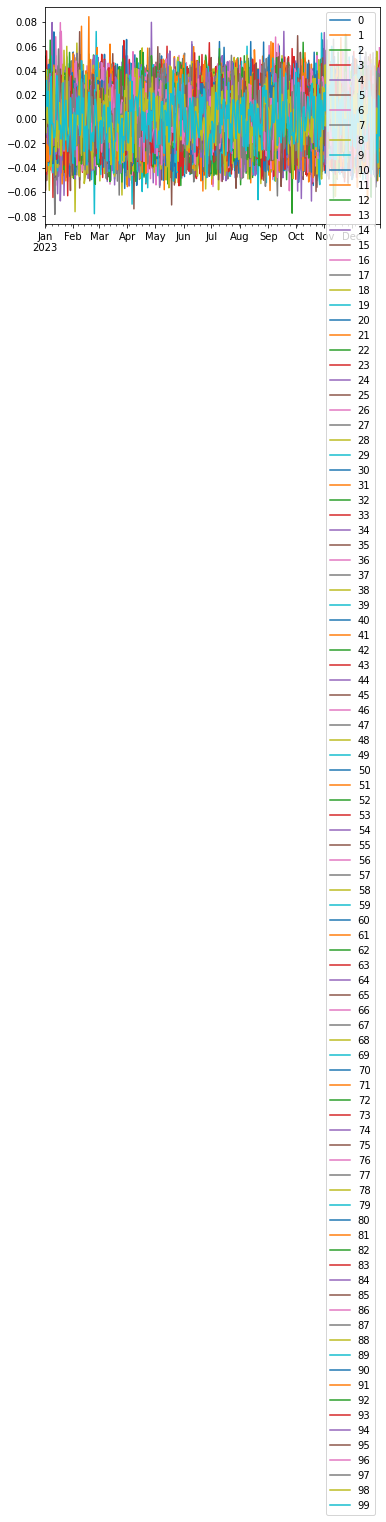

In [49]:
# rendimientos simulados para el 2023 con N=100 (100 simulaciones de montecarlo)
precios_siguientes.plot()

## 3. Proyección de precios de cierre

Por tanto, para calcular los precios, tenemos:

$$\begin{align}
p_i&=p_{i-1}(R_i+1)\\
p_{i+1}&=p_i(R_{i+1}+1)=p_{i-1}(R_i+1)(R_{i+1}+1)\\
&\vdots\\
p_{i+k}&=p_{i-1}(R_i+1)\cdots(R_{i+k}+1).
\end{align}$$

Si hacemos $i=0$ en la última ecuación, tenemos que $p_{k}=p_{-1}\exp(r_0+\cdots+r_{k})$, donde $p_{-1}$ es el último precio reportado en el 2022.

Con los rendimientos, calculamos los precios de cierre...

In [51]:
precios_siguientes[1] # Ri  rendimientos diaros del 2023 de un escenario 

2023-01-01   -0.005704
2023-01-02   -0.023351
2023-01-03   -0.001185
2023-01-04    0.002186
2023-01-05   -0.032589
                ...   
2023-12-27   -0.020720
2023-12-28    0.011231
2023-12-29   -0.015857
2023-12-30    0.010744
2023-12-31   -0.007824
Freq: D, Name: 1, Length: 365, dtype: float64

In [52]:
precios_siguientes[1].cumprod()

2023-01-01   -5.704211e-03
2023-01-02    1.331985e-04
2023-01-03   -1.578370e-07
2023-01-04   -3.450817e-10
2023-01-05    1.124601e-11
                  ...     
2023-12-27   -0.000000e+00
2023-12-28   -0.000000e+00
2023-12-29    0.000000e+00
2023-12-30    0.000000e+00
2023-12-31   -0.000000e+00
Freq: D, Name: 1, Length: 365, dtype: float64

In [53]:
closes['AAPL'].tail()

Date
2022-12-23    131.127045
2022-12-27    129.307251
2022-12-28    125.339417
2022-12-29    128.889572
2022-12-30    129.207794
Name: AAPL, dtype: float64

In [54]:
closes['AAPL'][-1]

129.20779418945312

In [55]:
# Obtenemos los precios apartir de la simulación de montecarlo
AAPL = closes['AAPL'][-1]*(precios_siguientes + 1).cumprod()

$$p_{i+k}&=p_{i-1}(R_i+1)\cdots(R_{i+k}+1)$$

In [57]:
AAPL.shape

(365, 100)

In [58]:
AAPL

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
2023-01-01,129.941398,128.470766,128.173137,127.067334,130.760486,126.401587,129.862888,127.449434,129.463156,127.452189,...,129.140902,126.000715,129.602442,129.632769,130.526311,131.276354,129.712731,131.171505,131.544505,128.966039
2023-01-02,133.450919,125.470857,125.447914,129.412050,133.842823,118.987556,131.001576,127.847655,132.218423,128.309761,...,130.642415,124.746970,133.400117,128.816566,130.948999,133.763249,130.454175,129.453974,130.032694,130.180368
2023-01-03,132.052205,125.322177,124.742172,129.921292,134.158068,118.836204,129.525753,128.840376,132.159844,133.096558,...,130.385493,119.433490,133.446982,126.877706,133.882631,137.434537,134.918468,129.491015,135.326062,134.315012
2023-01-04,132.571230,125.596171,125.835616,131.090857,131.274792,115.199746,131.704318,131.631348,131.534353,133.380589,...,127.523228,119.559248,132.556064,126.498150,131.147458,136.575236,136.947626,134.003667,135.556242,135.713532
2023-01-05,132.816272,121.503064,128.492922,133.020686,135.613454,114.419579,132.346688,130.644476,131.675736,132.634915,...,123.001168,115.393872,130.758028,125.880528,135.370963,137.219304,138.392149,137.584060,135.036189,138.830097
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-27,184.721256,169.785528,215.798633,127.265457,381.981465,136.465778,436.453784,446.162393,127.874890,134.014045,...,133.576891,100.246730,145.587873,103.362468,160.301933,134.607029,157.020799,228.939247,131.473232,121.517945
2023-12-28,179.743181,171.692459,214.664221,130.360902,382.783570,136.626996,445.590452,447.485974,133.091945,131.805993,...,135.941627,101.619541,146.229977,104.456850,163.296625,137.773945,155.842657,218.535064,132.664344,119.953897
2023-12-29,172.878890,168.969847,223.247035,128.897419,389.895691,135.433572,461.628267,443.765496,127.730520,126.372141,...,131.585733,97.069709,148.098922,102.545926,162.752935,137.077450,159.867953,223.870480,133.139501,115.625623
2023-12-30,179.411632,170.785215,222.268165,129.164182,395.069084,136.269113,454.309040,452.492381,125.500612,125.026766,...,131.684172,97.583756,152.231408,100.030874,169.590189,136.621803,162.833631,232.285426,127.818175,117.843277


Concatenamos y graficamos...

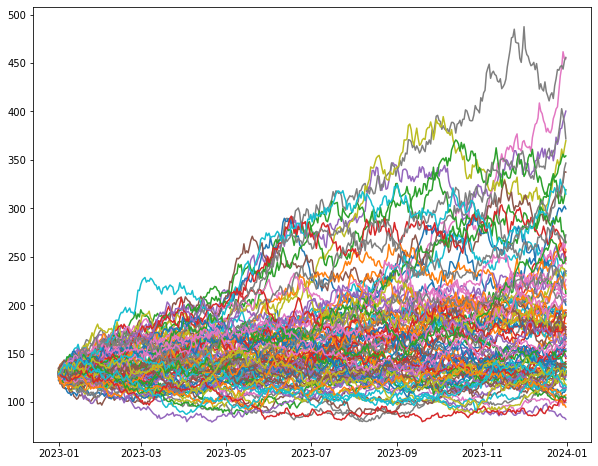

In [60]:
plt.figure(figsize=(10,8))
plt.plot(AAPL)
plt.show()

## 4. Probabilidad Precio-Umbral

Ya que tenemos muchos escenarios de precios proyectados, podemos ver varias cosas. Por ejemplo, ¿cuál es la probabilidad de que el precio de cierre sobrepase algún valor umbral en algún momento?

In [61]:
closes['AAPL'][-1]

129.20779418945312

In [62]:
umbral = closes['AAPL'][-1]*1.2 #Umbral del 20%
umbral

155.04935302734376

In [63]:
# Umbral de 10% del ultimo precio
umbral = closes['AAPL'][-1]*1.1 #Umbral del 10%
umbral

142.12857360839845

In [ ]:
rango = pd.date_range()

In [64]:
lista = [1,2,3,4]


In [73]:
lista[-1], lista[3]

(4, 4)

In [75]:
arreglo= np.array([1,2,3,4])
arreglo

array([1, 2, 3, 4])

In [77]:
arreglo[3], arreglo[-1]

(4, 4)

In [83]:
closes['AAPL'].tail()

Date
2022-12-23    131.127045
2022-12-27    129.307251
2022-12-28    125.339417
2022-12-29    128.889572
2022-12-30    129.207794
Name: AAPL, dtype: float64

In [82]:
closes['AAPL'][-1]

129.20779418945312

In [84]:
umbral

142.12857360839845

In [89]:
#Simulación para los precios de cierre
umbral = closes['AAPL'][-1]*1.1 #Umbral del 10%
rango = pd.date_range('2023-01-01', periods=365)
umbral_df = pd.DataFrame(data=umbral*np.ones(365), index = rango, columns=['umbral'])
AAPL_umbral = pd.concat([AAPL, umbral_df], axis=1)

In [90]:
umbral_df

,umbral
2023-01-01,142.128574
2023-01-02,142.128574
2023-01-03,142.128574
2023-01-04,142.128574
2023-01-05,142.128574
...,...
2023-12-27,142.128574
2023-12-28,142.128574
2023-12-29,142.128574
2023-12-30,142.128574


In [91]:
AAPL_umbral

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,umbral
2023-01-01,129.941398,128.470766,128.173137,127.067334,130.760486,126.401587,129.862888,127.449434,129.463156,127.452189,...,126.000715,129.602442,129.632769,130.526311,131.276354,129.712731,131.171505,131.544505,128.966039,142.128574
2023-01-02,133.450919,125.470857,125.447914,129.412050,133.842823,118.987556,131.001576,127.847655,132.218423,128.309761,...,124.746970,133.400117,128.816566,130.948999,133.763249,130.454175,129.453974,130.032694,130.180368,142.128574
2023-01-03,132.052205,125.322177,124.742172,129.921292,134.158068,118.836204,129.525753,128.840376,132.159844,133.096558,...,119.433490,133.446982,126.877706,133.882631,137.434537,134.918468,129.491015,135.326062,134.315012,142.128574
2023-01-04,132.571230,125.596171,125.835616,131.090857,131.274792,115.199746,131.704318,131.631348,131.534353,133.380589,...,119.559248,132.556064,126.498150,131.147458,136.575236,136.947626,134.003667,135.556242,135.713532,142.128574
2023-01-05,132.816272,121.503064,128.492922,133.020686,135.613454,114.419579,132.346688,130.644476,131.675736,132.634915,...,115.393872,130.758028,125.880528,135.370963,137.219304,138.392149,137.584060,135.036189,138.830097,142.128574
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-27,184.721256,169.785528,215.798633,127.265457,381.981465,136.465778,436.453784,446.162393,127.874890,134.014045,...,100.246730,145.587873,103.362468,160.301933,134.607029,157.020799,228.939247,131.473232,121.517945,142.128574
2023-12-28,179.743181,171.692459,214.664221,130.360902,382.783570,136.626996,445.590452,447.485974,133.091945,131.805993,...,101.619541,146.229977,104.456850,163.296625,137.773945,155.842657,218.535064,132.664344,119.953897,142.128574
2023-12-29,172.878890,168.969847,223.247035,128.897419,389.895691,135.433572,461.628267,443.765496,127.730520,126.372141,...,97.069709,148.098922,102.545926,162.752935,137.077450,159.867953,223.870480,133.139501,115.625623,142.128574
2023-12-30,179.411632,170.785215,222.268165,129.164182,395.069084,136.269113,454.309040,452.492381,125.500612,125.026766,...,97.583756,152.231408,100.030874,169.590189,136.621803,162.833631,232.285426,127.818175,117.843277,142.128574


In [93]:
prob = AAPL > umbral
prob

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
2023-01-01,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2023-01-02,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2023-01-03,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2023-01-04,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2023-01-05,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-27,True,True,True,False,True,False,True,True,False,False,...,False,False,True,False,True,False,True,True,False,False
2023-12-28,True,True,True,False,True,False,True,True,False,False,...,False,False,True,False,True,False,True,True,False,False
2023-12-29,True,True,True,False,True,False,True,True,False,False,...,False,False,True,False,True,False,True,True,False,False
2023-12-30,True,True,True,False,True,False,True,True,False,False,...,False,False,True,False,True,False,True,True,False,False


In [94]:
media_umbral = np.mean(prob, axis=1)
media_umbral

2023-01-01    0.00
2023-01-02    0.00
2023-01-03    0.00
2023-01-04    0.00
2023-01-05    0.01
              ... 
2023-12-27    0.65
2023-12-28    0.64
2023-12-29    0.63
2023-12-30    0.63
2023-12-31    0.63
Freq: D, Length: 365, dtype: float64

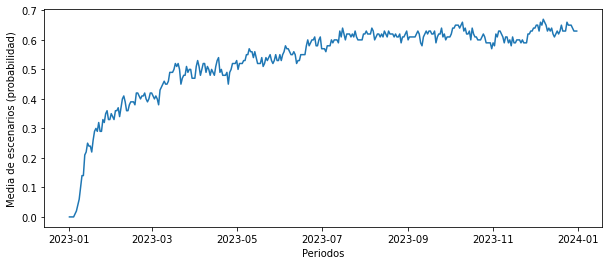

In [96]:
plt.figure(figsize=(10,4))
plt.plot(media_umbral)
plt.xlabel('Periodos')
plt.ylabel('Media de escenarios (probabilidad)')
plt.show()

In [ ]:
def simu_montecarlo_precio_umbral(tickers, start_Date, end_Date, start_simulation, periods):
    
    return media_umbral # como dataframe para todos los tockers que se añaden como arg de entrada a la funcio

In [ ]:
simu_montecarlo_precio_umbral(tickers=['WMT', 'MSFT'], start_Date='2020-01-01', end_Date='2023-10-01'
                             start_simulation='2023-10-01', periods=365)

#### 

___
Entonces, ya aprendimos a bajar datos con pandas-datareader. En específico, a partir de los precios de cierre ajustados obtuvimos los rendimientos diarios.

Suponiendo que los rendimientos diarios son un proceso estocástico estacionario de distribución normal, pudimos caracaterizarlo y proyectar varios escenarios de evolución de los precios (montecarlo).

Con estas proyecciones pudimos calcular probabilidades de sobrepasar cierto precio umbral: toma de decisiones.

### Actividad:
Obtener la probabilidad precio umbral para Walmart, Tesla y Micorsoft.

## 23 de Noviembre EXAMEN Módulo 2
## 27 de Noviembre Presentación de Proyecto Módulo 2